# Importing Libraries

In [1]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix,mean_squared_error
import warnings
from math import sqrt

In [3]:
warnings.simplefilter('ignore')

#EDA

In [4]:
train=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Stock Price/NSE_train.csv')
test=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Stock Price/NSE_test.csv')

In [5]:
train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-01,12202.150391,12222.200195,12165.299805,12182.500000,12182.500000,304100
1,2020-01-02,12198.549805,12289.900391,12195.250000,12282.200195,12282.200195,407700
2,2020-01-03,12261.099609,12265.599609,12191.349609,12226.650391,12226.650391,428800
3,2020-01-06,12170.599609,12179.099609,11974.200195,11993.049805,11993.049805,396500
4,2020-01-07,12079.099609,12152.150391,12005.349609,12052.950195,12052.950195,447800


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 991 entries, 0 to 990
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       991 non-null    object 
 1   Open       991 non-null    float64
 2   High       991 non-null    float64
 3   Low        991 non-null    float64
 4   Close      991 non-null    float64
 5   Adj Close  991 non-null    float64
 6   Volume     991 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 54.3+ KB


In [ ]:
# train['Date'] = pd.to_datetime(train['Date'])
# test['Date'] = pd.to_datetime(test['Date'])

In [ ]:
# train = train.set_index(train['Date']).sort_index() # setting date feature as our index
# print(train.shape)
# train.head(5)

In [ ]:
# test = test.set_index(test['Date']).sort_index() # setting date feature as our index
# print(test.shape)
# test.head(5)

In [7]:
import plotly.graph_objs as go
import plotly

In [8]:
fig = go.Figure(data=[go.Candlestick(x=train['Date'],
                                    open=train['Open'],
                high=train['High'],
                low=train['Low'],
                close=train['Close'])])
fig.show()

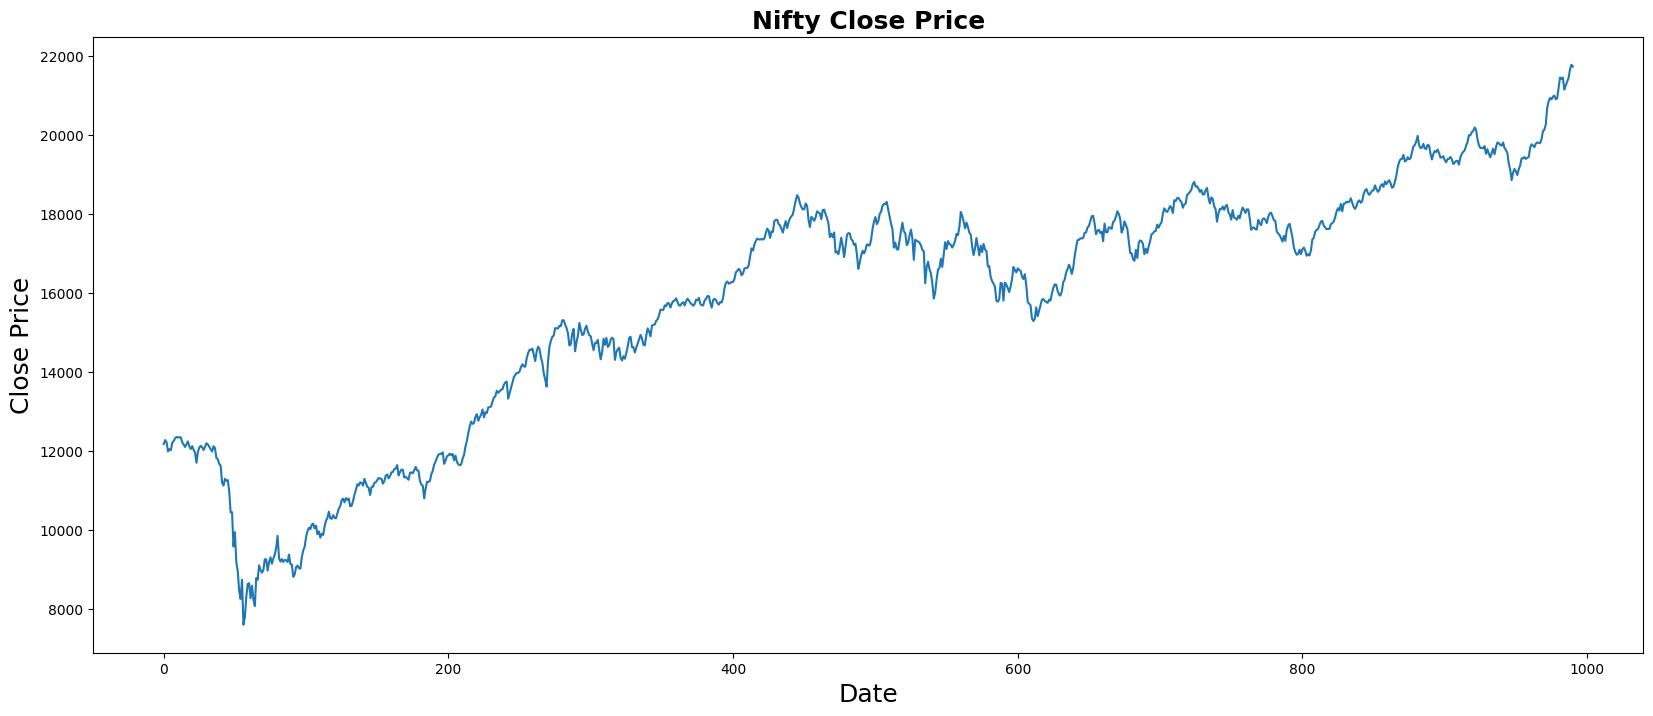

In [9]:
plt.figure(figsize = (20,8))
plt.plot(train[['Close']])
# plt.xticks(range(0,train.shape[0],30),train['Date'].loc[::30],rotation=45)
plt.title("Nifty Close Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price',fontsize=18)
plt.show()

arima parameters:

p: auto regressive term, it considers the impact of the past p values on the current value.

d: degree of differencing, This parameter addresses non-stationarity in the data, meaning the trend or seasonality changes over time. Differencing involves subtracting the previous value from the current value. The value of d indicates how many times this differencing is performed to achieve stationarity.
to fit arima, we need time series to be stationary, d is responsible to make it stationary.

q: moving average term, size of the moving average window. It basically considers the average of past residuals (errors) to account for randomness in the data.

ADF testing: test to check if price series is stationary
if p-value >0.05, then price series is non stationary
therefore, we need to find the value of d

In [10]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(train.Close.dropna())
print(f"ADF Statistics: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistics: -0.32968272876368565
p-value: 0.9211938930187618


# Splitting the Data

In [11]:
train_close=train.iloc[:,4:5].values
test_close=test.iloc[:,4:5].values

In [12]:
train_set, val_set = train_close[0:900], train_close[900:len(train)]

# Training ARIMA Model

# Experiment 1

random values of p,d and q assigned to get a starting point for optimization

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
# p=2, d=1. q=0
predictions1=[]
val_df=train[900:]
history=[x for x in train_set]
for t in range(len(val_set)):
 model1 = ARIMA(history, order=(2,1,0))
 result1 = model1.fit()
 output = result1.forecast()
 yhat = output[0]
 predictions1.append(yhat)
 history.append(val_set[t])

val_rmse = sqrt(mean_squared_error(val_set, predictions1))
val_df['Predictions']=predictions1

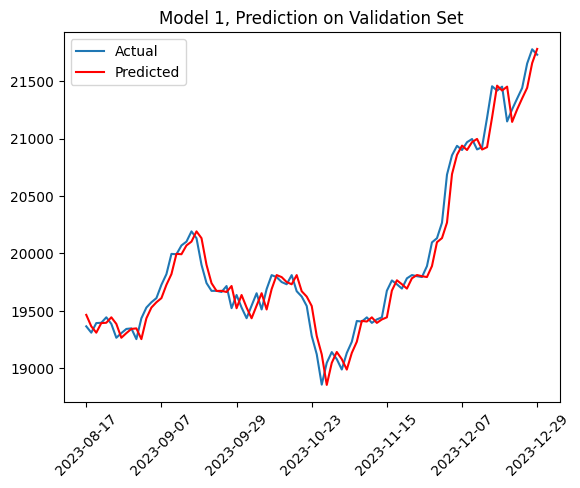

In [ ]:
plt.plot(val_set, label='Actual')
plt.xticks(range(0,val_df.shape[0],15),val_df['Date'].loc[::15],rotation=45)
plt.plot(predictions1, color='red', label='Predicted')
plt.title("Model 1, Prediction on Validation Set")
plt.legend()
plt.show()


In [ ]:
predictions1=[]

for t in range(len(test_close)):
 model1 = ARIMA(history, order=(2,1,0))
 result1 = model1.fit()
 output = result1.forecast()
 yhat = output[0]
 predictions1.append(yhat)
 history.append(test_close[t])
test_rmse = sqrt(mean_squared_error(test_close, predictions1))

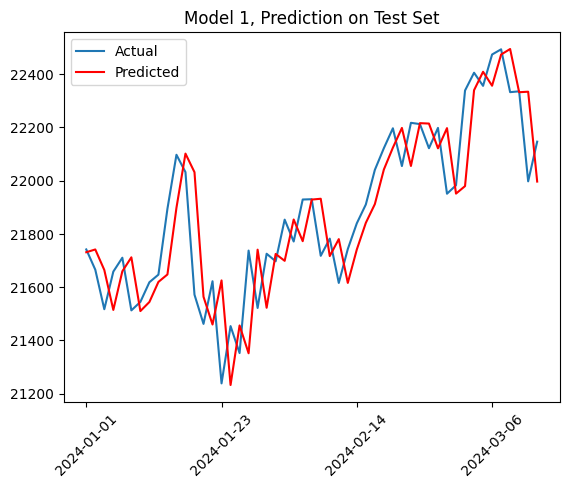

In [ ]:
plt.plot(test_close, label='Actual')
plt.plot(predictions1, color='red', label='Predicted')
plt.title("Model 1, Prediction on Test Set")
plt.xticks(range(0,test.shape[0],15),test['Date'].loc[::15],rotation=45)
plt.legend()
plt.show()

In [ ]:
print(result1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1041
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -6785.793
Date:                Mon, 18 Mar 2024   AIC                          13577.587
Time:                        14:24:02   BIC                          13592.428
Sample:                             0   HQIC                         13583.217
                               - 1041                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0027      0.024      0.116      0.908      -0.044       0.049
ar.L2          0.0104      0.020      0.530      0.596      -0.028       0.049
sigma2      2.726e+04    729.244     37.381      0.0

if coeff is very very small or P is large, then we remove it

as we can see in the above summary, the P value is very large.
therefore, we need to fine tune the parameters.

In [ ]:
print("Model 1")
print(f"Validation RMSE: {val_rmse}")
print(f"Test RMSE: {test_rmse}")

Model 1
Validation RMSE: 125.54340948699777
Test RMSE: 172.9953734834154


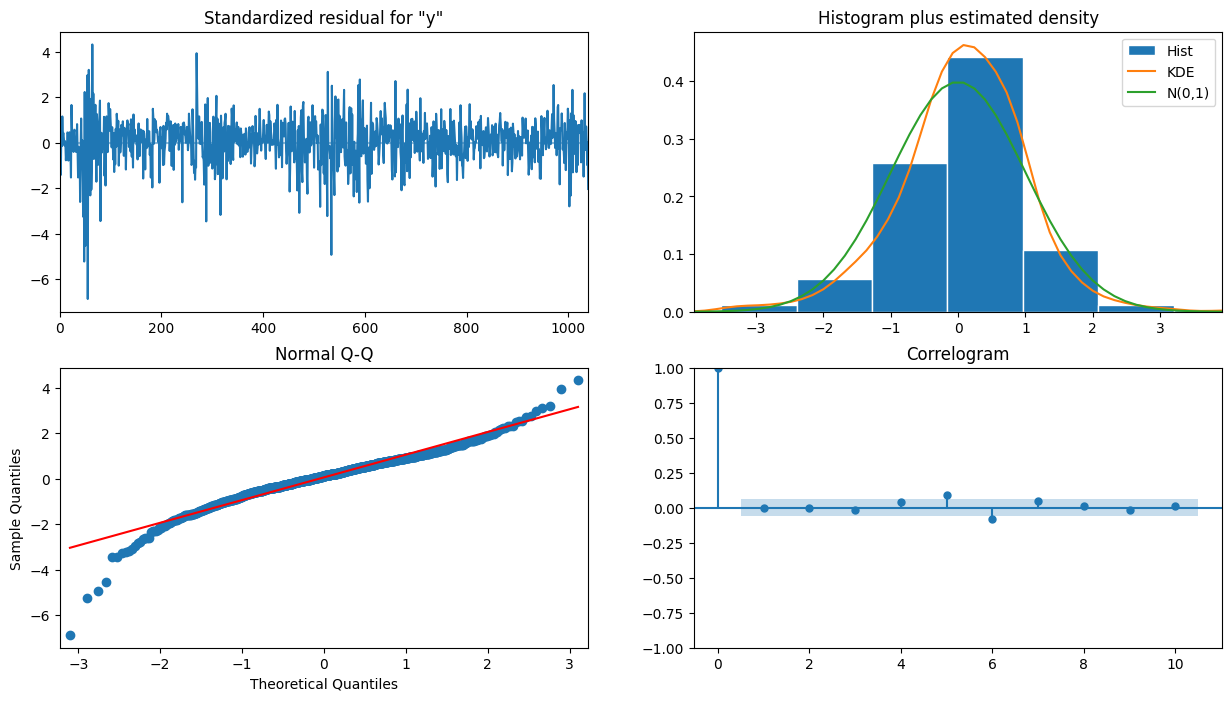

In [ ]:
result1.plot_diagnostics(figsize=(15,8));

residuals - difference between fitted (yhat) and actual value


# Experiment 2

trying to find the parameter values using graphs

acf plots will tell us how many terms are required to be subtracted to make the series stationary, i.e. value of hyperparameter 'd'

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

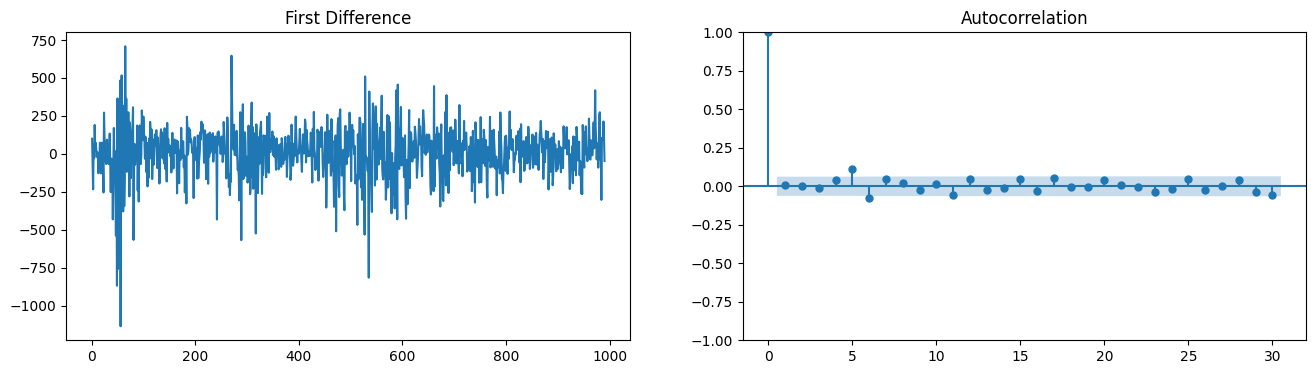

In [ ]:
# first difference
diff=train.Close.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))
ax1.plot(diff)
ax1.set_title('First Difference')
plot_acf(diff,ax=ax2);

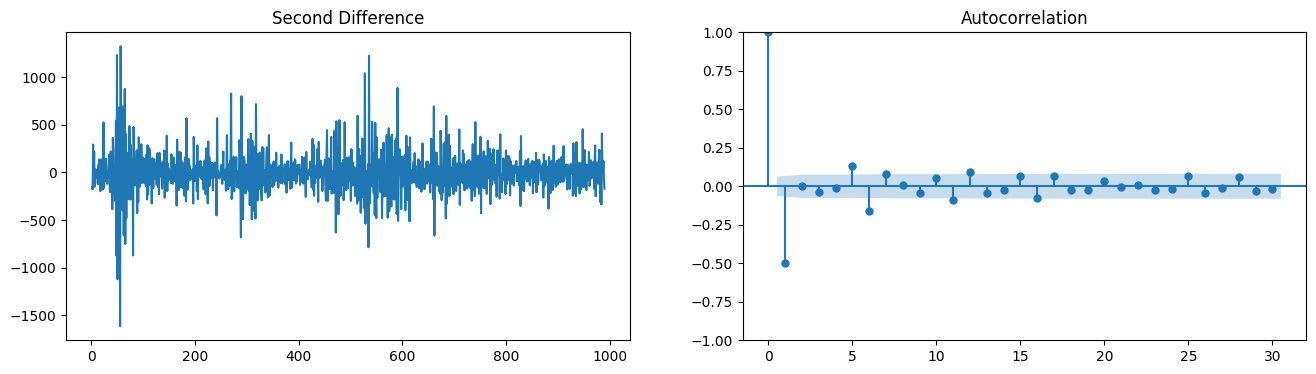

In [ ]:
# second difference
diff=train.Close.diff().diff().dropna()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))
ax1.plot(diff)
ax1.set_title('Second Difference')
plot_acf(diff,ax=ax2);

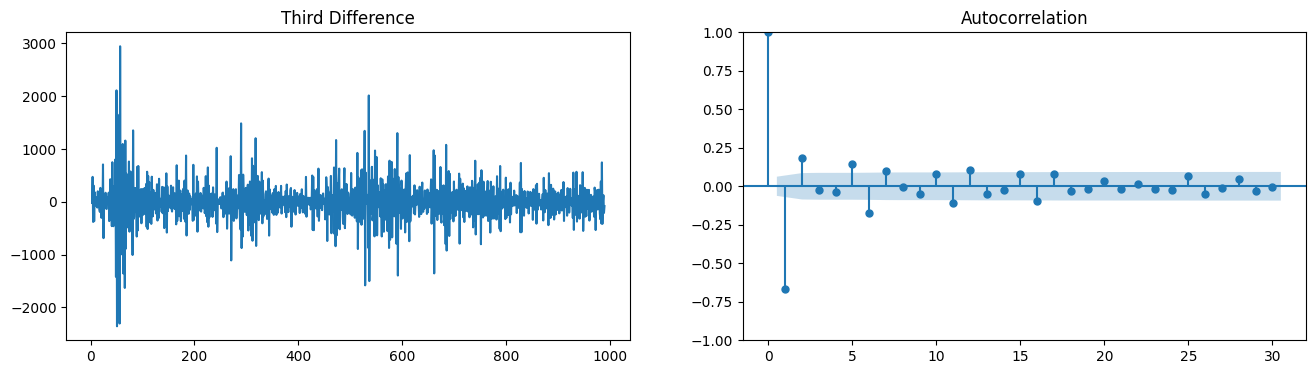

In [ ]:
# third difference
diff=train.Close.diff().diff().diff().dropna()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))
ax1.plot(diff)
ax1.set_title('Third Difference')
plot_acf(diff,ax=ax2);

as the autocorrelation value is decreasing, as we increase the no of differences, this shows that we are over differencing
so suited value could be 1 or maybe 2

In [ ]:
# to verify the above value, we use pmdarima ndiff
from pmdarima.arima.utils import ndiffs
ndiffs(train.Close, test='adf')

1

to identify the value of p, we will use partial acf graph

(0.0, 1.0)

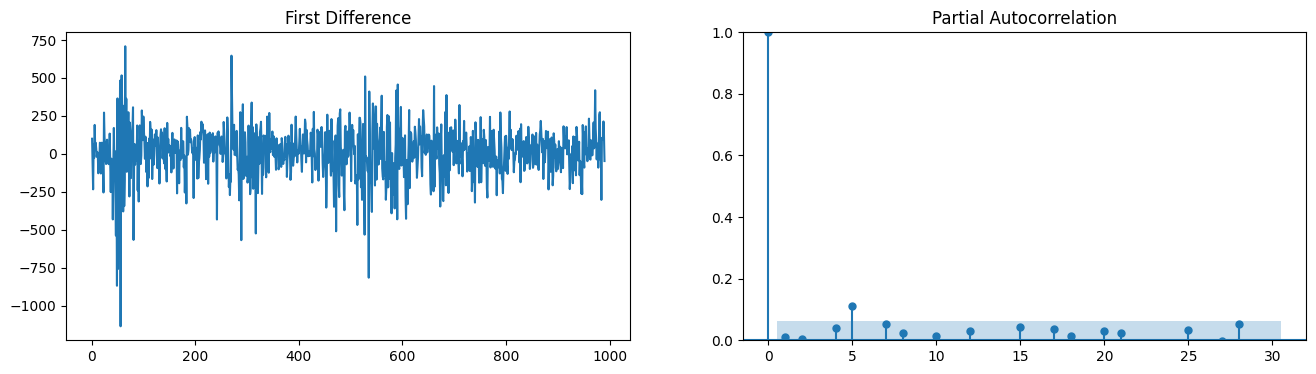

In [ ]:
# first difference
diff=train.Close.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))
ax1.plot(diff)
ax1.set_title('First Difference')
plot_pacf(diff,ax=ax2);
ax2.set_ylim(0,1)

value of hyperparameter p = 5

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
predictions2=[]
history=[x for x in train_set]
for t in range(len(val_set)):
 model2 = ARIMA(history, order=(5,1,2))
 result2 = model2.fit()
 output = result2.forecast()
 yhat = output[0]
 predictions2.append(yhat)
 history.append(val_set[t])

val_rmse = sqrt(mean_squared_error(val_set, predictions2))

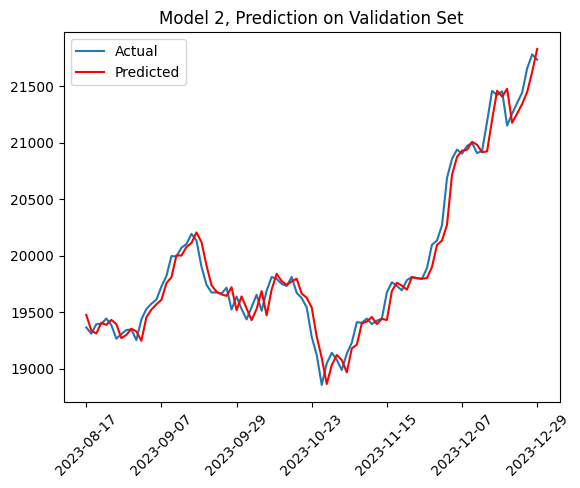

In [ ]:
plt.plot(val_set, label='Actual')
plt.xticks(range(0,val_df.shape[0],15),val_df['Date'].loc[::15],rotation=45)
plt.plot(predictions2, color='red', label='Predicted')
plt.title("Model 2, Prediction on Validation Set")
plt.legend()
plt.show()


In [ ]:
predictions2=[]

for t in range(len(test_close)):
 model2 = ARIMA(history, order=(5,1,2))
 result2 = model2.fit()
 output = result2.forecast()
 yhat = output[0]
 predictions2.append(yhat)
 history.append(test_close[t])

test_rmse = sqrt(mean_squared_error(test_close, predictions2))

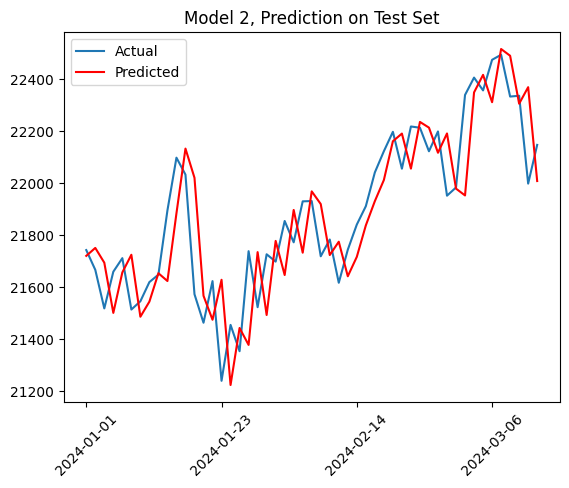

In [ ]:
plt.plot(test_close, label='Actual')
plt.plot(predictions2, color='red', label='Predicted')
plt.title("Model 2, Prediction on Test Set")
plt.xticks(range(0,test.shape[0],15),test['Date'].loc[::15],rotation=45)
plt.legend()
plt.show()

In [ ]:
print(result2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1041
Model:                 ARIMA(5, 1, 2)   Log Likelihood               -6775.597
Date:                Mon, 18 Mar 2024   AIC                          13567.193
Time:                        14:27:40   BIC                          13606.769
Sample:                             0   HQIC                         13582.206
                               - 1041                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8906      0.156     -5.696      0.000      -1.197      -0.584
ar.L2         -0.3964      0.134     -2.966      0.003      -0.658      -0.134
ar.L3         -0.0069      0.035     -0.195      0.8

In [ ]:
print("Model 2")
print(f"Validation RMSE: {val_rmse}")
print(f"Test RMSE: {test_rmse}")

Model 2
Validation RMSE: 126.07432792422996
Test RMSE: 179.38867361031134


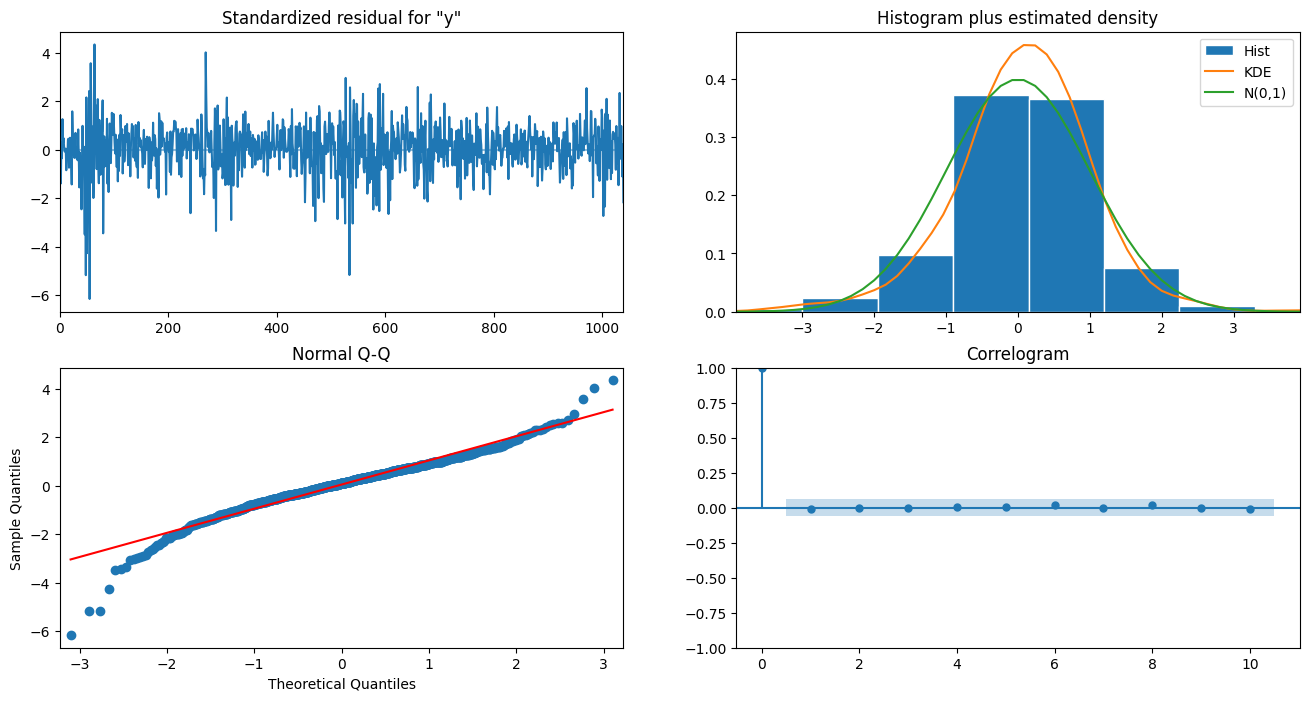

In [ ]:
result2.plot_diagnostics(figsize=(16,8));

# Experiment 3 (AutoArima)

using auto arima model to find the best suited parameters

In [13]:
from pmdarima.arima import auto_arima

In [ ]:
model_autoARIMA = auto_arima(train_set, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11766.140, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11768.136, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11768.139, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11766.233, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11770.139, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.476 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  900
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -5881.070
Date:                Mon, 18 Mar 2024   AIC                          11766.140
Time:                        14:27:41   BIC                          11775.743
Sample:                             0   HQIC                         11769.808
                                - 900                                  

In [20]:
help(auto_arima)

Help on function auto_arima in module pmdarima.arima.auto:

auto_arima(y, X=None, start_p=2, d=None, start_q=2, max_p=5, max_d=2, max_q=5, start_P=1, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=1, seasonal=True, stationary=False, information_criterion='aic', alpha=0.05, test='kpss', seasonal_test='ocsb', stepwise=True, n_jobs=1, start_params=None, trend=None, method='lbfgs', maxiter=50, offset_test_args=None, seasonal_test_args=None, suppress_warnings=True, error_action='trace', trace=False, random=False, random_state=None, n_fits=10, return_valid_fits=False, out_of_sample_size=0, scoring='mse', scoring_args=None, with_intercept='auto', sarimax_kwargs=None, **fit_args)
    Automatically discover the optimal order for an ARIMA model.
    
    The auto-ARIMA process seeks to identify the most optimal
    parameters for an ``ARIMA`` model, settling on a single fitted ARIMA model.
    This process is based on the commonly-used R function,
    ``forecast::auto.arima`` [3].


In [ ]:
predictions3=[]
val_df=train[900:]
history=[x for x in train_set]
for t in range(len(val_set)):
 model3 = ARIMA(history, order=(0,1,0))
 result3 = model3.fit()
 output = result3.forecast()
 yhat = output[0]
 predictions3.append(yhat)
 history.append(val_set[t])

val_df['Predictions']=predictions3
val_rmse = sqrt(mean_squared_error(val_set, predictions3))


In [ ]:
len(history)

991

In [ ]:
val_df

,Date,Open,High,Low,Close,Adj Close,Volume,Predictions
900,2023-08-17,19450.550781,19461.550781,19326.250000,19365.250000,19365.250000,268700,19465.000000
901,2023-08-18,19301.750000,19373.800781,19253.599609,19310.150391,19310.150391,256100,19365.250000
902,2023-08-21,19320.650391,19425.949219,19296.300781,19393.599609,19393.599609,262600,19310.150391
903,2023-08-22,19417.099609,19443.500000,19381.300781,19396.449219,19396.449219,208700,19393.599609
904,2023-08-23,19439.199219,19472.050781,19366.599609,19444.000000,19444.000000,225200,19396.449219
...,...,...,...,...,...,...,...,...
986,2023-12-22,21295.849609,21390.500000,21232.449219,21349.400391,21349.400391,284700,21255.050781
987,2023-12-26,21365.199219,21477.150391,21329.449219,21441.349609,21441.349609,219500,21349.400391
988,2023-12-27,21497.650391,21675.750000,21495.800781,21654.750000,21654.750000,256500,21441.349609
989,2023-12-28,21715.000000,21801.449219,21678.000000,21778.699219,21778.699219,393100,21654.750000


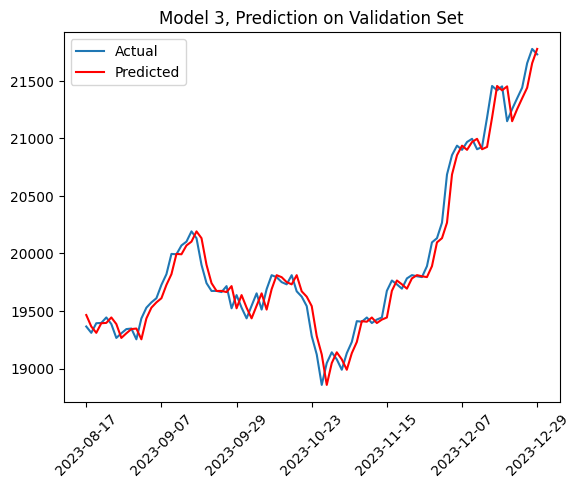

In [ ]:
plt.plot(val_set, label='Actual')
plt.xticks(range(0,val_df.shape[0],15),val_df['Date'].loc[::15],rotation=45)
plt.plot(predictions3, color='red', label='Predicted')
plt.title("Model 3, Prediction on Validation Set")
plt.legend()
plt.show()


In [ ]:
predictions3=[]
test_df=test
for t in range(len(test_close)):
 model3 = ARIMA(history, order=(0,1,0))
 result3 = model3.fit()
 output = result3.forecast()
 yhat = output[0]
 predictions3.append(yhat)
 history.append(test_close[t])

test_df['Predictions']=predictions3
test_rmse = sqrt(mean_squared_error(test_close, predictions3))

In [ ]:
len(history)

1042

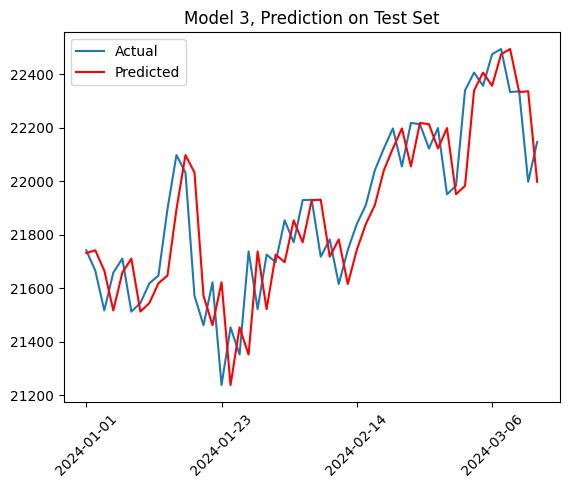

In [ ]:
plt.plot(test_close, label='Actual')
plt.plot(predictions3, color='red', label='Predicted')
plt.title("Model 3, Prediction on Test Set")
plt.xticks(range(0,test.shape[0],15),test['Date'].loc[::15],rotation=45)
plt.legend()
plt.show()

In [ ]:
print(result3.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1041
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -6785.853
Date:                Mon, 18 Mar 2024   AIC                          13573.706
Time:                        14:27:45   BIC                          13578.653
Sample:                             0   HQIC                         13575.583
                               - 1041                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       2.72e+04    666.565     40.802      0.000    2.59e+04    2.85e+04
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1041.52
Prob(Q):                              0.95   Pr

In [ ]:
print("Model 3")
print(f"Validation RMSE: {val_rmse}")
print(f"Test RMSE: {test_rmse}")

Model 3
Validation RMSE: 125.76161768544296
Test RMSE: 172.60814074462203


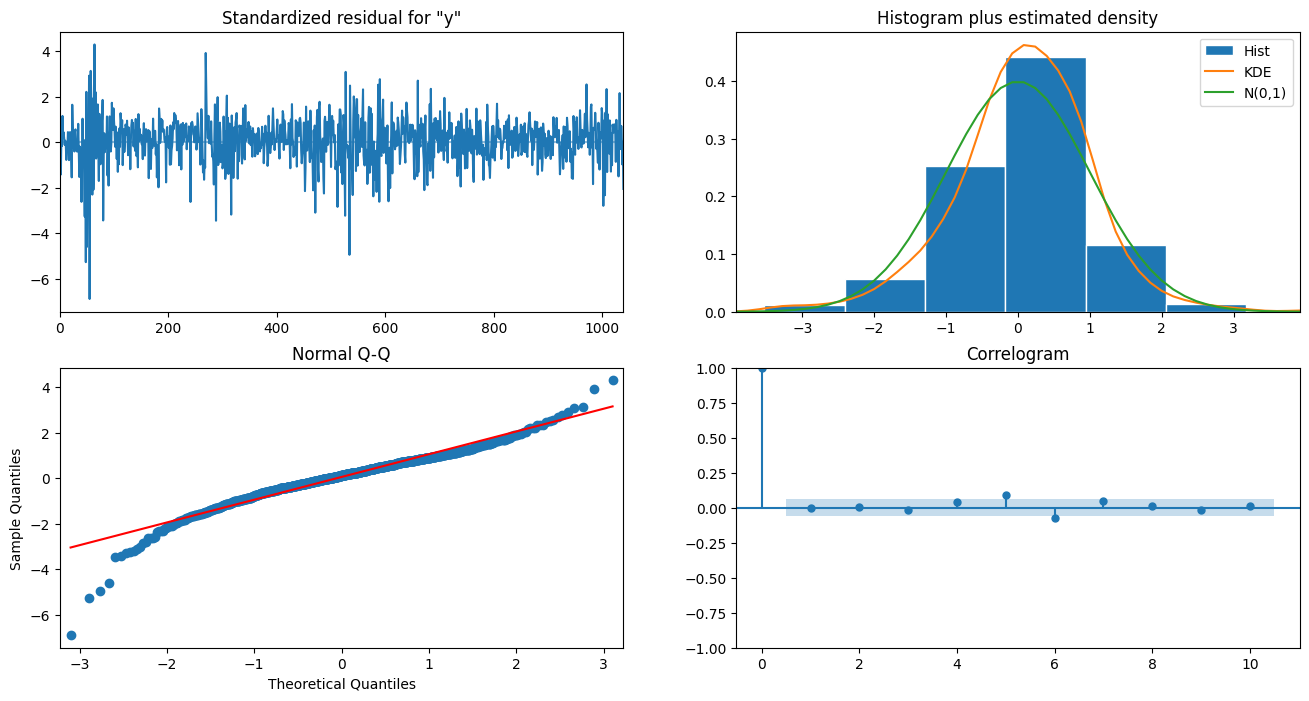

In [ ]:
result3.plot_diagnostics(figsize=(16,8));

In [ ]:
model3 = ARIMA(history, order=(0,1,0))
result3 = model3.fit()
output = result3.forecast()
yhat = output[0]
print(yhat)

22146.650390625


# Experiment 4 (GridSearchCV)

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
def evaluate_arima_model(train_set, val_set, arima_order):
 # prepare training dataset
 history = [x for x in train_set]
 # make predictions
 predictions = list()
 for t in range(len(val_set)):
  model = ARIMA(history, order=arima_order)
  model_fit = model.fit()
  yhat = model_fit.forecast()[0]
  predictions.append(yhat)
  history.append(val_set[t])
  # calculate out of sample error
 rmse = sqrt(mean_squared_error(val_set, predictions))
 return rmse

In [ ]:
def evaluate_models(train_set, val_set, p_values, d_values, q_values):
 best_score, best_cfg = float("inf"), None
 for p in p_values:
  for d in d_values:
    for q in q_values:
      order = (p,d,q)
      try:
        rmse = evaluate_arima_model(train_set, val_set, order)
        if rmse < best_score:
          best_score, best_cfg = rmse, order
        print('ARIMA%s RMSE=%.3f' % (order,rmse))
      except:
        continue
  print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))


# evaluate parameters
p_values = [0, 1, 2, 4, 6]
d_values = range(0, 4)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(train_set, val_set, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=4382.374
ARIMA(0, 0, 1) RMSE=2248.754
ARIMA(0, 0, 2) RMSE=1328.959
ARIMA(0, 1, 0) RMSE=125.762
ARIMA(0, 1, 1) RMSE=125.555
ARIMA(0, 1, 2) RMSE=125.540
ARIMA(0, 2, 0) RMSE=151.368
ARIMA(0, 2, 1) RMSE=124.318
ARIMA(0, 2, 2) RMSE=124.059
ARIMA(0, 3, 0) RMSE=250.108
ARIMA(0, 3, 1) RMSE=151.457
ARIMA(0, 3, 2) RMSE=123.602
Best ARIMA(0, 3, 2) RMSE=123.602
ARIMA(1, 0, 0) RMSE=126.758
ARIMA(1, 0, 1) RMSE=126.486
ARIMA(1, 0, 2) RMSE=126.551
ARIMA(1, 1, 0) RMSE=125.552
ARIMA(1, 1, 1) RMSE=125.568
ARIMA(1, 1, 2) RMSE=125.507
ARIMA(1, 2, 0) RMSE=141.462
ARIMA(1, 2, 1) RMSE=124.077
ARIMA(1, 2, 2) RMSE=124.179
ARIMA(1, 3, 0) RMSE=200.468
ARIMA(1, 3, 1) RMSE=141.454
ARIMA(1, 3, 2) RMSE=123.467
Best ARIMA(1, 3, 2) RMSE=123.467
ARIMA(2, 0, 0) RMSE=126.453
ARIMA(2, 0, 1) RMSE=126.347
ARIMA(2, 0, 2) RMSE=126.955
ARIMA(2, 1, 0) RMSE=125.543
ARIMA(2, 1, 1) RMSE=125.504
ARIMA(2, 1, 2) RMSE=124.623
ARIMA(2, 2, 0) RMSE=136.988
ARIMA(2, 2, 1) RMSE=124.098
ARIMA(2, 2, 2) RMSE=124.473
ARIMA(2

In [ ]:
predictions4=[]
history=[x for x in train_set]
for t in range(len(val_set)):
 model4 = ARIMA(history, order=(1,3,2))
 result4 = model4.fit()
 output = result4.forecast()
 yhat = output[0]
 predictions4.append(yhat)
 history.append(val_set[t])

val_rmse = sqrt(mean_squared_error(val_set, predictions4))

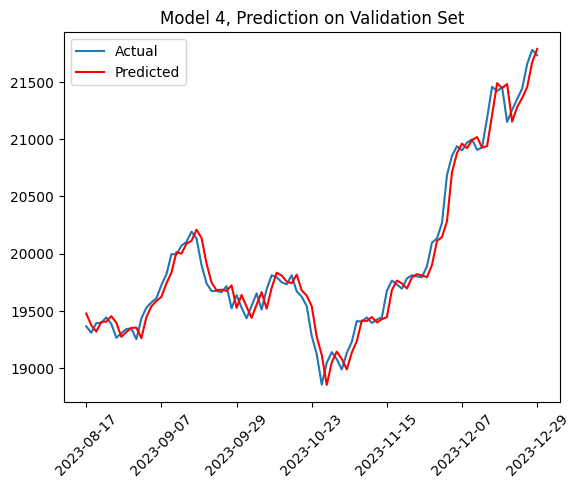

In [ ]:
plt.plot(val_set, label='Actual')
plt.xticks(range(0,val_df.shape[0],15),val_df['Date'].loc[::15],rotation=45)
plt.plot(predictions4, color='red', label='Predicted')
plt.title("Model 4, Prediction on Validation Set")
plt.legend()
plt.show()


In [ ]:
predictions4=[]

for t in range(len(test_close)):
 model4 = ARIMA(history, order=(1,3,2))
 result4 = model4.fit()
 output = result4.forecast()
 yhat = output[0]
 predictions4.append(yhat)
 history.append(test_close[t])

test_rmse = sqrt(mean_squared_error(test_close, predictions4))

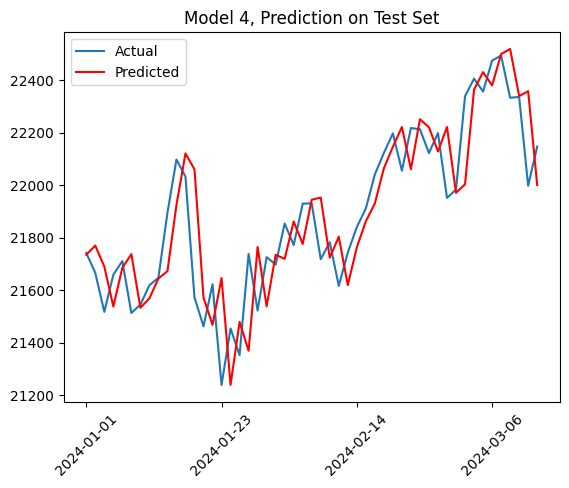

In [ ]:
plt.plot(test_close, label='Actual')
plt.plot(predictions4, color='red', label='Predicted')
plt.title("Model 4, Prediction on Test Set")
plt.xticks(range(0,test.shape[0],15),test['Date'].loc[::15],rotation=45)
plt.legend()
plt.show()

In [ ]:
print(result4.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1041
Model:                 ARIMA(1, 3, 2)   Log Likelihood               -6793.563
Date:                Mon, 18 Mar 2024   AIC                          13595.127
Time:                        16:43:08   BIC                          13614.907
Sample:                             0   HQIC                         13602.631
                               - 1041                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0120      0.020      0.594      0.552      -0.028       0.052
ma.L1         -1.9993      0.017   -118.207      0.000      -2.032      -1.966
ma.L2          0.9993      0.017     59.114      0.0

In [ ]:
print("Model 4")
print(f"Validation RMSE: {val_rmse}")
print(f"Test RMSE: {test_rmse}")

Model 4
Validation RMSE: 123.46747659071035
Test RMSE: 175.47045813776657


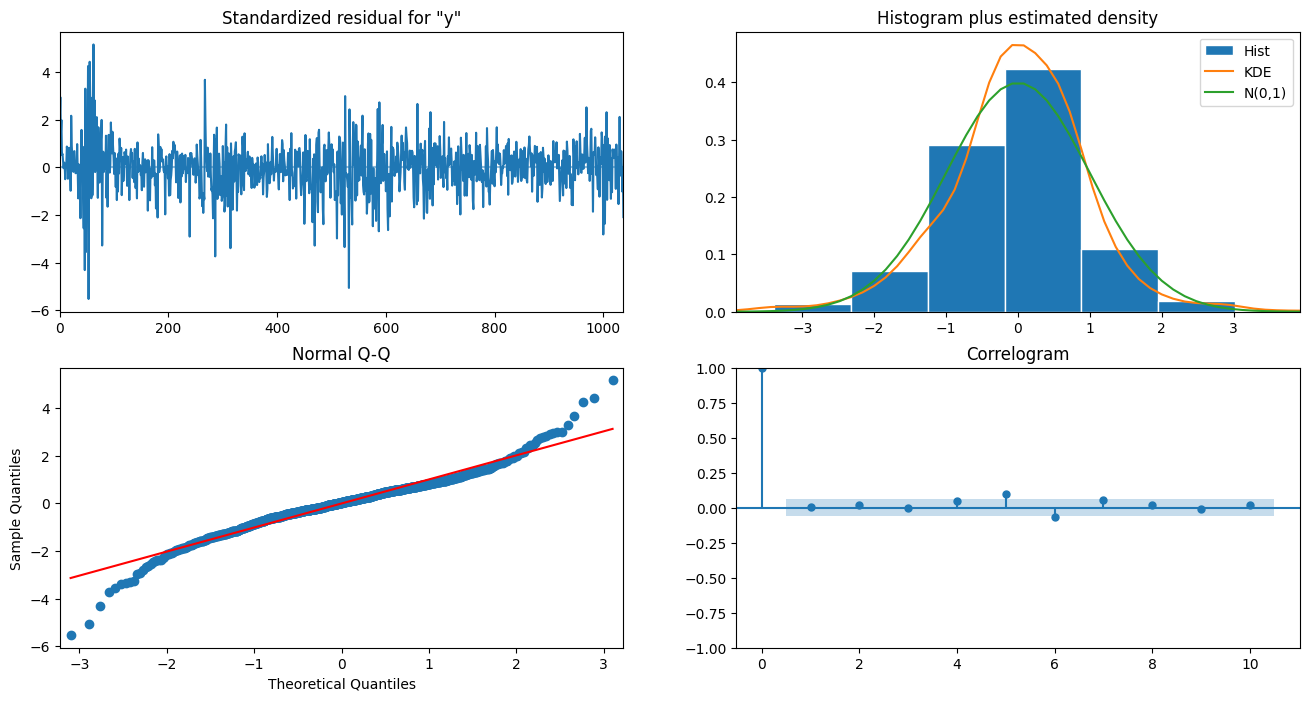

In [ ]:
result4.plot_diagnostics(figsize=(16,8));

In [ ]:
model4 = ARIMA(history, order=(1,3,2))
result4 = model4.fit()
output = result4.forecast()
yhat = output[0]
print(yhat)

22155.70001806036


performance

model---val rmse---test rmse

-----1-----125.543-----172.995

-----2-----126.074-----179.388

-----3-----125.761-----172.608

-----4-----123.467-----175.470